In [1]:
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
results = {}

for name in [x.replace("log/", "") for x in glob.glob("log/*")]:
    last_epoch = 0
    results[name] = []
    output_files = sorted(glob.glob("log/" + name + "/1*_output.txt"))
    for file in output_files:
        with open(file, "r") as f:
            log = f.read()
            parsed = re.findall(r"(Train|Eval|Test), epoch: (?P<epoch>\d)\nAmount pixel truth aneurym: (?P<truth>\d*)\nAmount pixel predicted aneurym: (?P<predicted>\d*)\nDifference: (?P<difference>[-]*\d*)\nLoss: (?P<loss>\d*\.\d*)", log)
            parsed = [{"type": x[0].lower(), "epoch": int(x[1]) + last_epoch, "loss": float(x[5]), "error": int(x[4])/int(x[2])} for x in parsed]
            
            results[name] += parsed
            last_epoch = last_epoch + parsed[-1]["epoch"] + 1
            
tidy_results = []
for k, v in results.items():
    for item in v:
        x = {"testrun": k}
        x.update(item)
        tidy_results.append(x)

df = pd.DataFrame(tidy_results)
l = df.pivot(index=("testrun", "epoch"), columns="type", values="loss")
l = l.add_prefix("loss_").rename_axis(None, axis=1).reset_index()
r = df.pivot(index=("testrun", "epoch"), columns="type", values="error")
r = r.add_prefix("error_").rename_axis(None, axis=1).reset_index()

df = pd.merge(l, r, on=("testrun", "epoch"))
df.head()

,testrun,epoch,loss_eval,loss_train,error_eval,error_train
0,lr0001_BCE,0,0.015600,0.084967,-1.000000,7.804901
1,lr0001_BCE,1,0.012954,0.014143,-1.000000,-1.000000
2,lr0001_BCE,2,0.012107,0.012457,-1.000000,-1.000000
3,lr0001_BCE,3,0.010611,0.011108,-1.000000,-1.000000
4,lr0001_BCE,4,0.009937,0.009997,-0.994419,-0.999860


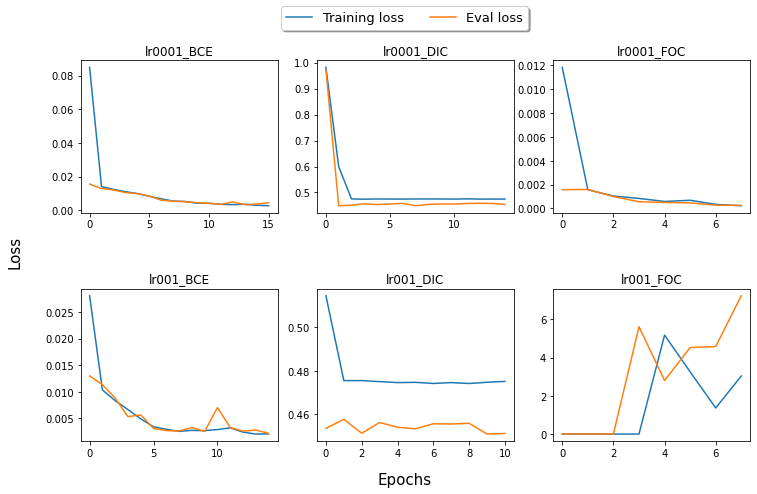

In [30]:
value = 'loss'

grouped = df[df['testrun'].str.startswith('lr')].groupby('testrun')
fig, axs = plt.subplots(figsize=(12,7), 
                        nrows=2, ncols=3,
                        gridspec_kw=dict(hspace=.5, wspace=.2))


axes = axs.flatten()

for i, (title, group) in enumerate(grouped):
    axes[i].plot(group["epoch"], group[value + "_train"])
    axes[i].plot(group["epoch"], group[value + "_eval"])
    axes[i].set_title(title)

fig.text(0.5, 0.04, 'Epochs', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Loss', va='center', fontsize=15, rotation='vertical')

fig.legend(["Training " + value, "Eval " + value], loc='upper center', shadow=True, fontsize=13, bbox_to_anchor=(0.5, 1), ncol=2)
 
plt.savefig("results.png", transparent=False, facecolor="w")